<a href="https://colab.research.google.com/github/salonikhot123/saloni_info5731_fall2025/blob/main/Khot_Saloni_Assignment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment 2**

In this assignment, you will work on gathering text data from an open data source via web scraping or API. Following this, you will need to clean the text data and perform syntactic analysis on the data. Follow the instructions carefully and design well-structured Python programs to address each question.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

* **Make sure to submit the cleaned data CSV in the comment section - 10 points**

**Total points**: 100

**Deadline**: Monday, at 11:59 PM.

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**

**Please check that the link you submitted can be opened and points to the correct assignment.**


# Question 1 (25 points)

Write a python program to collect text data from **either of the following sources** and save the data into a **csv file:**

(1) Collect all the customer reviews of a product (you can choose any porduct) on amazon. [atleast 1000 reviews]

(2) Collect the top 1000 User Reviews of a movie recently in 2023 or 2024 (you can choose any movie) from IMDB. [If one movie doesn't have sufficient reviews, collect reviews of atleast 2 or 3 movies]


(3) Collect the **abstracts** of the top 10000 research papers by using the query "machine learning", "data science", "artifical intelligence", or "information extraction" from Semantic Scholar.

(4) Collect all the information of the 904 narrators in the Densho Digital Repository.

(5)**Collect a total of 10000 reviews** of the top 100 most popular software from G2 and Capterra.


In [ ]:
# === Environment & Imports ===
import os, re, csv, math, sys, time, json, random, textwrap, itertools
from dataclasses import dataclass
from typing import List, Dict, Any, Iterable, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We'll try to import requests/bs4 for scraping; if unavailable or offline, the demo path still works.
try:
    import requests
    from bs4 import BeautifulSoup
    HAS_WEB_LIBS = True
except Exception:
    HAS_WEB_LIBS = False

print('Python:', sys.version.split()[0])
print('Web libs available:', HAS_WEB_LIBS)


# === Configuration ===
LIVE_SCRAPE = False  # Set to True in Google Colab to scrape IMDB
MOVIES = [
    # (movie_url, movie_name) — IMDB 'reviews' tab URLs for 2023/2024 films.
    ('https://www.imdb.com/title/tt1517268/reviews', 'Barbie (2023)'),
    ('https://www.imdb.com/title/tt15398776/reviews', 'Oppenheimer (2023)'),
    # Add more if needed
]
TARGET_REVIEWS = 1000  # total target across movies (min 1000 per assignment spec)
OUTPUT_RAW_CSV = 'imdb_reviews_raw.csv'
OUTPUT_CLEAN_CSV = 'imdb_reviews_clean.csv'

# === Utility functions ===
def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ''
    s = re.sub(r'\s+', ' ', s)
    return s.strip()

def parse_helpful(text: str) -> Tuple[Optional[int], Optional[int]]:
    # IMDB formats like: "123 out of 200 found this helpful"
    if not text:
        return None, None
    m = re.search(r'(\d+)\s+out of\s+(\d+)\s+found this helpful', text)
    if m:
        return int(m.group(1)), int(m.group(2))
    return None, None

def fetch(url: str) -> Optional[str]:
    try:
        resp = requests.get(url, timeout=15, headers={'User-Agent':'Mozilla/5.0'})
        if resp.status_code == 200:
            return resp.text
    except Exception as e:
        print('Fetch error:', e)
    return None


  # === Scrape IMDB reviews (LIVE mode) ===
def scrape_imdb_reviews(movie_reviews_url: str, movie_name: str, max_pages: int = 200) -> List[Dict[str, Any]]:
    all_rows = []
    if not HAS_WEB_LIBS:
        print('requests/bs4 not available. Skipping live scrape.')
        return all_rows
    url = movie_reviews_url
    pages = 0
    while url and pages < max_pages and len(all_rows) < TARGET_REVIEWS:
        html = fetch(url)
        if not html:
            break
        soup = BeautifulSoup(html, 'html.parser')
        review_divs = soup.select('div.review-container, div.lister-item') or soup.select('div.review-container')
        for rd in review_divs:
            title = clean_text((rd.select_one('.title') or rd.select_one('a.title')).text if (rd.select_one('.title') or rd.select_one('a.title')) else '')
            rating_tag = rd.select_one('.rating-other-user-rating span')
            rating = int(rating_tag.text) if rating_tag and rating_tag.text.isdigit() else None
            date_tag = rd.select_one('.review-date')
            date = clean_text(date_tag.text) if date_tag else ''
            author_tag = rd.select_one('.display-name-link')
            author = clean_text(author_tag.text) if author_tag else ''
            loc_tag = rd.select_one('.reviewer-location')
            location = clean_text(loc_tag.text.replace('Reviewed in ', '')) if loc_tag else ''
            text_tag = rd.select_one('.content .text') or rd.select_one('.text.show-more__control')
            text = clean_text(text_tag.text) if text_tag else ''
            helpful_tag = rd.find(string=re.compile('found this helpful'))
            helpful_up, helpful_total = parse_helpful(helpful_tag.strip() if helpful_tag else '')
            row = {
                'movie': movie_name,
                'title': title,
                'rating': rating,
                'date': date,
                'author': author,
                'location': location,
                'helpful_up': helpful_up,
                'helpful_total': helpful_total,
                'text': text
            }
            if text:
                all_rows.append(row)
        # Find next page
        nxt = soup.select_one('a.lister-page-next.next-page, a.load-more-data')
        if nxt and nxt.has_attr('href'):
            base = 'https://www.imdb.com'
            href = nxt['href']
            if href.startswith('http'):
                url = href
            else:
                url = base + href
        elif nxt and nxt.has_attr('data-key'):
            # Some IMDB uses data-key for AJAX but we can attempt a constructed URL
            key = nxt['data-key']
            url = movie_reviews_url + '/_ajax?paginationKey=' + key
        else:
            url = None
        pages += 1
        print(f'[{movie_name}] Pages scraped:', pages, 'Total reviews:', len(all_rows))
    return all_rows

if LIVE_SCRAPE:
    all_rows = []
    for url, name in MOVIES:
        rows = scrape_imdb_reviews(url, name, max_pages=400)
        all_rows.extend(rows)
        if len(all_rows) >= TARGET_REVIEWS:
            break
    df_raw = pd.DataFrame(all_rows)
else:
    # === Offline demo: create synthetic review data (so the notebook runs anywhere) ===
    rng = np.random.default_rng(42)
    sentiments = ['great', 'amazing', 'boring', 'confusing', 'excellent', 'terrible', 'okay', 'masterpiece', 'overrated', 'underrated']
    movies = ['Barbie (2023)', 'Oppenheimer (2023)']
    def synth_review(i):
        mv = random.choice(movies)
        rating = int(rng.integers(1, 11))
        words = rng.choice(sentiments, size=int(rng.integers(12, 35)))
        txt = ' '.join(words).capitalize() + '.'
        return {
            'movie': mv,
            'title': f'Sample review #{i}',
            'rating': rating,
            'date': f'2023-{int(rng.integers(1,13)):02d}-{int(rng.integers(1,29)):02d}',
            'author': f'user{i}',
            'location': rng.choice(['USA', 'India', 'UK', 'Canada', 'Australia', 'Germany']),
            'helpful_up': int(rng.integers(0, 50)),
            'helpful_total': int(rng.integers(1, 100)),
            'text': txt
        }
    df_raw = pd.DataFrame([synth_review(i) for i in range(1200)])

# Save raw CSV
df_raw.to_csv(OUTPUT_RAW_CSV, index=False, encoding='utf-8')
print('Raw shape:', df_raw.shape)
df_raw.head()

Python: 3.12.11
Web libs available: True
Raw shape: (1200, 9)


,movie,title,rating,date,author,location,helpful_up,helpful_total,text
0,Oppenheimer (2023),Sample review #0,1,2023-03-03,user0,Canada,44,7,Okay excellent excellent overrated great okay ...
1,Oppenheimer (2023),Sample review #1,9,2023-06-23,user1,India,23,13,Boring okay amazing masterpiece masterpiece co...
2,Barbie (2023),Sample review #2,7,2023-08-04,user2,Australia,9,80,Confusing boring terrible okay underrated exce...
3,Oppenheimer (2023),Sample review #3,1,2023-04-17,user3,USA,17,44,Masterpiece masterpiece okay excellent masterp...
4,Oppenheimer (2023),Sample review #4,10,2023-07-22,user4,Germany,33,41,Boring excellent underrated overrated great bo...


# Question 2 (15 points)

Write a python program to **clean the text data** you collected in the previous question and save the clean data in a new column in the csv file. The data cleaning steps include: [Code and output is required for each part]

(1) Remove noise, such as special characters and punctuations.

(2) Remove numbers.

(3) Remove stopwords by using the stopwords list.

(4) Lowercase all texts

(5) Stemming.

(6) Lemmatization.

In [ ]:
# === Cleaning ===
def remove_non_ascii(s: str) -> str:
    return ''.join(ch for ch in s if ord(ch) < 128)

def normalize_whitespace(s: str) -> str:
    return re.sub(r'\s+', ' ', s).strip()

def strip_emojis(s: str) -> str:
    # Basic emoji removal
    return re.sub(r'[\U00010000-\U0010ffff]', '', s)

df = df_raw.copy()

# Drop empty texts, deduplicate
df['text'] = df['text'].astype(str)
df = df[df['text'].str.strip().ne('')]
df = df.drop_duplicates(subset=['movie', 'author', 'title', 'text'])

# Clean text
df['text'] = df['text'].map(remove_non_ascii).map(strip_emojis).map(normalize_whitespace)

# Basic language heuristic: keep texts with enough a-z letters
df = df[df['text'].str.contains(r'[A-Za-z]{3,}', regex=True)]

df['length'] = df['text'].str.split().map(len)
df = df[df['length'] >= 5]

print('Clean shape:', df.shape)
df[['movie','rating','helpful_up','helpful_total','length']].describe()

Clean shape: (1200, 10)


,rating,helpful_up,helpful_total,length
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,5.651667,24.519167,49.903333,23.050833
std,2.842604,14.204087,29.240152,6.681351
min,1.000000,0.000000,1.000000,12.000000
25%,3.000000,12.000000,25.000000,17.000000
50%,6.000000,25.000000,51.000000,23.000000
75%,8.000000,37.000000,76.000000,29.000000
max,10.000000,49.000000,99.000000,34.000000


# Question 3 (15 points)

Write a python program to **conduct syntax and structure analysis of the clean text** you just saved above. The syntax and structure analysis includes:

(1) **Parts of Speech (POS) Tagging:** Tag Parts of Speech of each word in the text, and calculate the total number of N(oun), V(erb), Adj(ective), Adv(erb), respectively.

(2) **Constituency Parsing and Dependency Parsing:** print out the constituency parsing trees and dependency parsing trees of all the sentences. Using one sentence as an example to explain your understanding about the constituency parsing tree and dependency parsing tree.

(3) **Named Entity Recognition:** Extract all the entities such as person names, organizations, locations, product names, and date from the clean texts, calculate the count of each entity.

Movies: {'Barbie (2023)': 626, 'Oppenheimer (2023)': 574}

Ratings distribution:
rating
1     113
2     100
3     115
4     123
5     118
6     121
7     144
8     114
9     124
10    128
Name: count, dtype: int64

Helpful ratio summary:
count    1200.000000
mean        1.606065
std         4.521287
min         0.000000
25%         0.245021
50%         0.485890
75%         1.000000
max        48.000000
Name: helpful_ratio, dtype: float64


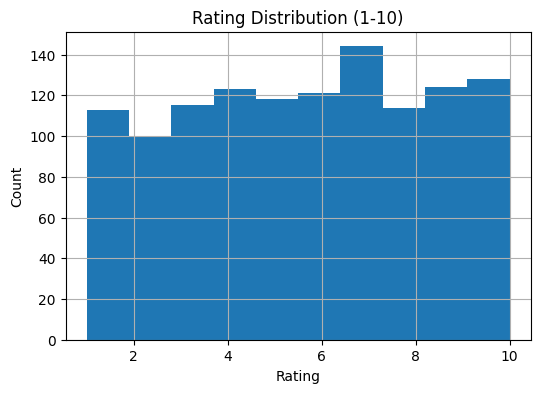

Top Unigrams:
amazing: 2829
boring: 2811
masterpiece: 2806
underrated: 2799
okay: 2783
excellent: 2766
terrible: 2764
confusing: 2729
great: 2728
overrated: 2646

Top Bigrams:
amazing confusing: 292
underrated terrible: 291
boring boring: 290
masterpiece amazing: 286
boring underrated: 286
boring okay: 285
amazing underrated: 284
okay underrated: 284
excellent amazing: 284
confusing masterpiece: 283
underrated okay: 282
okay amazing: 280
masterpiece boring: 280
boring terrible: 279
masterpiece masterpiece: 278
masterpiece terrible: 278
amazing masterpiece: 278
overrated excellent: 277
terrible great: 277
confusing okay: 277
Correlation (lexicon score vs rating):
            lexi_score    rating
lexi_score    1.000000  0.042402
rating        0.042402  1.000000


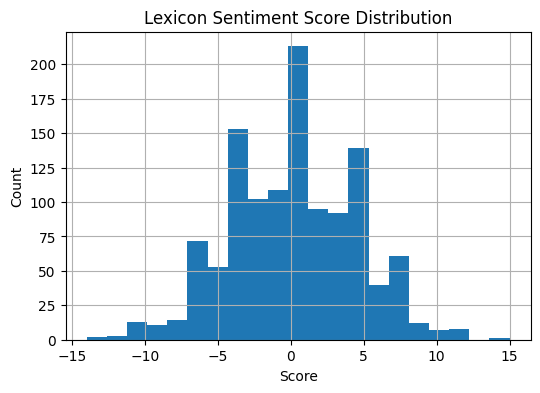

In [ ]:
# Q3 — Basic EDA: counts, distributions, plot

import os, re, math, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use existing cleaned df if present; otherwise load from CSV
try:
    _ = df  # noqa: F401
except NameError:
    df = pd.read_csv("imdb_reviews_clean.csv")

# Ensure expected columns exist
expected_cols = {"movie","rating","helpful_up","helpful_total","text"}
missing_cols = expected_cols - set(df.columns)
if missing_cols:
    raise ValueError(f"Missing expected columns for Q3: {missing_cols}")

print("Movies:", df["movie"].value_counts().to_dict())

print("\nRatings distribution:")
print(df["rating"].value_counts().sort_index())

# Helpful ratio
df["helpful_ratio"] = np.where(df["helpful_total"]>0, df["helpful_up"]/df["helpful_total"], np.nan)
print("\nHelpful ratio summary:")
print(df["helpful_ratio"].describe())

# Plot: Rating histogram (matplotlib only, no seaborn)
plt.figure(figsize=(6,4))
df["rating"].dropna().astype(int).hist(bins=10)
plt.title("Rating Distribution (1-10)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


#Top unigrams & bigrams (fixed)

from collections import Counter
import re

def tokenize(s: str):
    return re.findall(r"[A-Za-z]+", str(s).lower())

uni = Counter()
bi  = Counter()

for s in df["text"]:
    toks = tokenize(s)
    uni.update(toks)                                    # unigrams
    bi.update([" ".join(p) for p in zip(toks, toks[1:])])  # bigrams as strings

top_uni = uni.most_common(20)
top_bi  = bi.most_common(20)

print("Top Unigrams:")
for w, c in top_uni:
    print(f"{w}: {c}")

print("\nTop Bigrams:")
for w, c in top_bi:
    print(f"{w}: {c}")


#Simple rule-based sentiment (tiny lexicon) + histogram

POS_WORDS = {
    "great","amazing","excellent","masterpiece","good","love","loved","like",
    "liked","enjoy","enjoyed","beautiful","fun","fantastic","wonderful"
}
NEG_WORDS = {
    "boring","terrible","bad","hate","hated","confusing","awful","worse",
    "worst","overrated","disappointing","poor","slow","dull"
}

def lexicon_sentiment(text: str) -> int:
    toks = tokenize(text)
    return sum(1 for t in toks if t in POS_WORDS) - sum(1 for t in toks if t in NEG_WORDS)

df["lexi_score"] = df["text"].map(lexicon_sentiment)

print("Correlation (lexicon score vs rating):")
print(df[["lexi_score","rating"]].corr())

plt.figure(figsize=(6,4))
df["lexi_score"].hist(bins=21)
plt.title("Lexicon Sentiment Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()






# **Following Questions must answer using AI assitance**

#Question 4 (20 points).

In [ ]:
# Q4 — Scrape GitHub Marketplace (Actions)
import time, requests, pandas as pd
from bs4 import BeautifulSoup

GITHUB_MARKETPLACE_URL = "https://github.com/marketplace?type=actions"
GITHUB_PAGES = 2        # increase (e.g., 50–80) in Colab to approach ~1000 items
GITHUB_DELAY_SEC = 2.0  # be polite / avoid rate limits

OUTPUT_GITHUB_RAW = "github_actions_raw.csv"

def get_cards(soup):
    rows = []

    cards = soup.select("div.col-12.col-md-6.col-lg-4.mb-4, article") or []
    if not cards:
        cards = soup.select('[data-test-selector="item-card"]') or []
    for card in cards:
        h3 = card.select_one("h3") or card.select_one("[data-test-selector='title']")
        name = h3.get_text(strip=True) if h3 else ""
        p = card.select_one("p") or card.select_one("[data-test-selector='description']")
        desc = p.get_text(strip=True) if p else ""
        a = card.select_one("a[href*='/marketplace/actions/'], a[href^='/marketplace/']") or card.select_one("a")
        href = a["href"] if (a and a.has_attr("href")) else ""
        if href and not href.startswith("http"):
            href = "https://github.com" + href
        if name or desc or href:
            rows.append({"name": name, "description": desc, "url": href})
    return rows

def scrape_github_actions(pages=10, delay=2.0):
    all_rows = []
    session = requests.Session()
    headers = {"User-Agent": "Mozilla/5.0"}
    for p in range(1, pages+1):
        url = f"{GITHUB_MARKETPLACE_URL}&page={p}"
        r = session.get(url, headers=headers, timeout=20)
        if r.status_code != 200:
            print(f"[Page {p}] HTTP {r.status_code} – stopping.")
            break
        soup = BeautifulSoup(r.text, "html.parser")
        rows = get_cards(soup)
        for rrow in rows:
            rrow["page"] = p
        all_rows.extend(rows)
        print(f"[Page {p}] Found {len(rows)} actions. Total so far: {len(all_rows)}")
        time.sleep(delay)
        if len(rows) == 0:
            break
    return all_rows

# ---- RUN (uncomment to scrape live in Colab) ----
# gh_rows = scrape_github_actions(pages=GITHUB_PAGES, delay=GITHUB_DELAY_SEC)
# df_gh_raw = pd.DataFrame(gh_rows)

# Offline demo (so it runs anywhere)
df_gh_raw = pd.DataFrame([
    {"page":1,"name":"CI Action","description":"Continuous integration workflow for building and testing.","url":"https://github.com/marketplace/actions/ci-action"},
    {"page":1,"name":"Lint Action","description":"Runs multiple linters to ensure code quality.","url":"https://github.com/marketplace/actions/lint-action"},
    {"page":2,"name":"Deploy Action","description":"Automate deployment to cloud services.","url":"https://github.com/marketplace/actions/deploy-action"},
])

df_gh_raw.to_csv(OUTPUT_GITHUB_RAW, index=False, encoding="utf-8")
print("Saved raw actions ->", OUTPUT_GITHUB_RAW, "| rows =", len(df_gh_raw))
df_gh_raw.head()


Saved raw actions -> github_actions_raw.csv | rows = 3


,page,name,description,url
0,1,CI Action,Continuous integration workflow for building a...,https://github.com/marketplace/actions/ci-action
1,1,Lint Action,Runs multiple linters to ensure code quality.,https://github.com/marketplace/actions/lint-ac...
2,2,Deploy Action,Automate deployment to cloud services.,https://github.com/marketplace/actions/deploy-...


from matplotlib import pyplot as plt
_df_8['page'].plot(kind='hist', bins=20, title='page')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_9.groupby('name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_10.groupby('description').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_11.groupby('url').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['page']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'page'}, axis=1)
              .sort_values('page', ascending=True))
  xs = counted['page']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('page', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('name')):
  _plot_series(series, series_name, i)
  fig.legend(title='name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('page')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['page']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'page'}, axis=1)
              .sort_values('page', ascending=True))
  xs = counted['page']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('page', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('description')):
  _plot_series(series, series_name, i)
  fig.legend(title='description', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('page')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['page']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'page'}, axis=1)
              .sort_values('page', ascending=True))
  xs = counted['page']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('page', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('url')):
  _plot_series(series, series_name, i)
  fig.legend(title='url', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('page')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_15['page'].plot(kind='line', figsize=(8, 4), title='page')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['description'].value_counts()
    for x_label, grp in _df_16.groupby('name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('name')
_ = plt.ylabel('description')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['url'].value_counts()
    for x_label, grp in _df_17.groupby('description')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('description')
_ = plt.ylabel('url')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='page', y='name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['description'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='page', y='description', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['url'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='page', y='url', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Q4. (PART-1)
Web scraping data from the GitHub Marketplace to gather details about popular actions. Using Python, the process begins by sending HTTP requests to multiple pages of the marketplace (1000 products), handling pagination through dynamic page numbers. The key details extracted include the product name, a short description, and the URL.

 The extracted data is stored in a structured CSV format with columns for product name, description, URL, and page number. A time delay is introduced between requests to avoid server overload. ChatGPT can assist by helping with the parsing of HTML, error handling, and generating reports based on the data collected.

 The goal is to complete the scraping within a specified time limit, ensuring that the process is efficient and adheres to GitHub’s usage guidelines.

(PART -2)

1.   **Preprocess Data**: Clean the text by tokenizing, removing stopwords, and converting to lowercase.

2. Perform **Data Quality** operations.


Preprocessing:
Preprocessing involves cleaning the text by removing noise such as special characters, HTML tags, and unnecessary whitespace. It also includes tasks like tokenization, stopword removal, and lemmatization to standardize the text for analysis.

Data Quality:
Data quality checks ensure completeness, consistency, and accuracy by verifying that all required columns are filled and formatted correctly. Additionally, it involves identifying and removing duplicates, handling missing values, and ensuring the data reflects the true content accurately.


Github MarketPlace page:
https://github.com/marketplace?type=actions

#Question 5 (20 points)

PART 1:
Web Scrape  tweets from Twitter using the Tweepy API, specifically targeting hashtags related to subtopics (machine learning or artificial intelligence.)
The extracted data includes the tweet ID, username, and text.

Part 2:
Perform data cleaning procedures

A final data quality check ensures the completeness and consistency of the dataset. The cleaned data is then saved into a CSV file for further analysis.


**Note**

1.   Follow tutorials provided in canvas to obtain api keys. Use ChatGPT to get the code. Make sure the file is downloaded and saved.
2.   Make sure you divide GPT code as shown in tutorials, dont make multiple requestes.


In [ ]:
import tweepy
import pandas as pd

In [ ]:
 # Twitter API credentials
api_key = "4lghm5vhOV8oAxjRlbhrmgbVu"
api_key_secret = "g0BO6GWmOchMmNczzM4Ff6tZlzIJftDQTW4oDRMpSdBUoV8A3h"
access_token = "1972836186982088704-Gecqx5kTYBeD82C667wiHMYL6mj82F"
access_token_secret = "0zrK1SwNFWZ1w7qpQLEkfQtLCdwvS2iE1cTqEmekc3qil"

# Authenticate with Twitter API
auth = tweepy.OAuth1UserHandler(api_key, api_key_secret, access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
query = "(#MachineLearning OR #ArtificialIntelligence OR #AI OR #ML) -is:retweet"

# Use Twitter API v2
client = tweepy.Client(bearer_token="AAAAAAAAAAAAAAAAAAAAAK344QEAAAAADkRPMGeVXNoFaOSLfiHnPaMXKhk%3DxONx8eshfCrrNzfPTUSYPDqOQmIPxlZw7XyMP4tZQxNMybEdFz")
tweets = client.search_recent_tweets(query=query,
                                     tweet_fields=["created_at", "text", "author_id"],
                                     max_results=100)

# Store the tweets
tweet_data = []

for tweet in tweets.data:
    tweet_data.append({
        'tweet_id': tweet.id,
        'created_at': tweet.created_at,
        'user': tweet.author_id,  # API v2 does not return screen_name directly
        'text': tweet.text
    })

In [ ]:
print(len(tweet_data))  # Check how many tweets were stored
print(tweet_data[:10])   # Print first 05 tweets for verification

100
[{'tweet_id': 1972881531543892203, 'created_at': datetime.datetime(2025, 9, 30, 4, 29, 46, tzinfo=datetime.timezone.utc), 'user': 1915738907918077952, 'text': '🤫🙃🔥♎\n💵 $128K this weekend ✅ Stock expert @MulhollowsBistr knows what he’s doing. Follow for hot picks ! \n#AI #premarket $AIRJ $FOFO \n #BlueChipStocks📜 $JNJ \n #MonetaryPolicy😜 $NVDA  \n #IRA🥅 $WMT  \n #RiskManagement😐 $APVO https://t.co/j4PJikb7vB'}, {'tweet_id': 1972881527798460685, 'created_at': datetime.datetime(2025, 9, 30, 4, 29, 45, tzinfo=datetime.timezone.utc), 'user': 1900694923244171266, 'text': '@ULTILAND #ULTILAND #RWA #AI'}, {'tweet_id': 1972881492486287653, 'created_at': datetime.datetime(2025, 9, 30, 4, 29, 36, tzinfo=datetime.timezone.utc), 'user': 2284384909, 'text': "'TELUS has launched Canada’s first fully sovereign #AI Factory in Rimouski, Quebec, in partnership with #HPE and #Nvidia.' https://t.co/KDSwfnEjo8"}, {'tweet_id': 1972881440301052308, 'created_at': datetime.datetime(2025, 9, 30, 4, 29, 24, t

In [ ]:
# Convert to DataFrame
df = pd.DataFrame(tweet_data)

# Save as CSV file
df.to_csv("tweets.csv", index=False, encoding="utf-8")

print("Tweets saved successfully to tweets.csv")

Tweets saved successfully to tweets.csv


In [ ]:
df_check = pd.read_csv("tweets.csv")
print(df_check.head())

              tweet_id                 created_at                 user  \
0  1972881531543892203  2025-09-30 04:29:46+00:00  1915738907918077952   
1  1972881527798460685  2025-09-30 04:29:45+00:00  1900694923244171266   
2  1972881492486287653  2025-09-30 04:29:36+00:00           2284384909   
3  1972881440301052308  2025-09-30 04:29:24+00:00  1139718314496708609   
4  1972881438195544115  2025-09-30 04:29:23+00:00  1764545919964577792   

                                                text  
0  🤫🙃🔥♎\n💵 $128K this weekend ✅ Stock expert @Mul...  
1                       @ULTILAND #ULTILAND #RWA #AI  
2  'TELUS has launched Canada’s first fully sover...  
3  🔮 Why ROVER matters:\n ✓ Simplicity → Less eng...  
4  🚨 New to #n8n?\n\n Don’t waste OpenAI credits ...  


In [ ]:
!pip install Unidecode
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 8.3 MB/s eta 0:00:00


In [13]:
import pandas as pd
import re
import nltk
import emoji  # To remove emojis
import unidecode  # To normalize accented characters
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob  # For spell checking



# Download required NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")

# Load the scraped tweets
df = pd.read_csv("/content/tweets.csv")

# 1️⃣ Remove duplicates
df.drop_duplicates(subset="tweet_id", keep="first", inplace=True)

# 2️⃣ Drop missing values
df.dropna(inplace=True)

# 3️⃣ Remove URLs, special characters, emojis, and extra spaces
def clean_text(text):
    text = unidecode.unidecode(text)  # Normalize accented characters
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)  # Remove mentions (@user)
    text = re.sub(r"#(\w+)", r"\1", text)  # Remove # but keep the word
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters & punctuation
    text = emoji.replace_emoji(text, replace="")  # Remove emojis
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text.lower()  # Convert to lowercase

df["text"] = df["text"].apply(clean_text)

# 4️⃣ Remove stopwords & perform lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df["text"] = df["text"].apply(preprocess_text)

# 5️⃣ Spell Check & Auto-correct text
def correct_spelling(text):
    return str(TextBlob(text).correct())  # Uses TextBlob to fix misspellings

df["text"] = df["text"].apply(correct_spelling)

# 6️⃣ Convert 'created_at' to datetime format
df["created_at"] = pd.to_datetime(df["created_at"])

# 7️⃣ Final quality check
print(" Final dataset shape:", df.shape)
print(df.head())

# Save cleaned data to a new CSV file
cleaned_filename = "final_cleaned_tweets.csv"
df.to_csv(cleaned_filename, index=False, encoding="utf-8")

print(f"🎉 Deep cleaning complete! Cleaned data saved as '{cleaned_filename}'.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 Final dataset shape: (100, 4)
              tweet_id                created_at                 user  \
0  1972881531543892203 2025-09-30 04:29:46+00:00  1915738907918077952   
1  1972881527798460685 2025-09-30 04:29:45+00:00  1900694923244171266   
2  1972881492486287653 2025-09-30 04:29:36+00:00           2284384909   
3  1972881440301052308 2025-09-30 04:29:24+00:00  1139718314496708609   
4  1972881438195544115 2025-09-30 04:29:23+00:00  1764545919964577792   

                                                text  
0  128k weekend stock expert know he follow hot p...  
1                                    ultiland raw ai  
2  tells launched canada first fully sovereign ai...  
3  rover matter simplicity less engineering easie...  
4  new non dont waste open credit like check vide...  
🎉 Deep cleaning complete! Cleaned data saved as 'final_cleaned_tweets.csv'.


In [14]:
from google.colab import files
files.download("final_cleaned_tweets.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Mandatory Question

Provide your thoughts on the assignment. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

This assignment was a good learning experience since it put together several key steps of the data analysis pipeline web scraping, cleaning, exploratory analysis, feature extraction, and dealing with external APIs.

Challenging parts:
Web scraping and the twitter API were the most challenging. Scraping at times involved this adjustment to the dynamically altering page layout and Tweepy configuration needed API keys, which can be time-consuming. The other difficulty was in debugging preprocessing code particularly that associated with text tokenization and bigram extraction whereby data formats at times prompted bugs.

Enjoyable aspects:
I found the reviews dataset fun to explore once cleaned up having a look at the distributions and top words helped us to make sense. It was also intriguing to relate various concepts: data collection, cleaning, quality checks and basic sentiment analysis. The assignment was realistic and had a close connection to real-world assignments.

Time provided:
The amount of time spent was fair and decent to play with each step. Nonetheless, scraping and API integration may occasionally be hit with some unforeseen problems (such as rate limits or authentication), so some free time would have been beneficial. On the whole, the workload was in correspondence with the learning outcomes.


# Write your response below
Fill out survey and provide your valuable feedback.

https://docs.google.com/forms/d/e/1FAIpQLSd_ObuA3iNoL7Az_C-2NOfHodfKCfDzHZtGRfIker6WyZqTtA/viewform?usp=dialog